# Make saliency and attention maps

Install the keras-vis latest update on master branch with (will only work with that version 0.5):
```
pip install git+https://github.com/raghakot/keras-vis.git -U
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from keras import activations
from keras.models import Model, load_model
# keras-vis needs scipy==1.2.1 not the latest!
from vis.visualization import visualize_saliency, visualize_cam
from vis.utils import utils
from helper_with_N import *

Using TensorFlow backend.


Load model and get an overview of the layers in it. The "*\_2" is for the alternative branch.

In [2]:
model = load_model("./final_ViraMiner/best_ViraMiner_end2end.hdf5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 5)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 293, 1000)    41000       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 290, 1200)    67200       input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 1000)         0           conv1d_1[0][0]                   
____________________________________________________________________________________________

Load some input sequence and transform it as done in the script

In [3]:
val_bps = []
val_seqs = []
val_labels = []
base_file = "./data/DNA_data/fullset"

f = open(base_file + "_validation.csv")
for line in f:
    line = line.strip()  # remove \n
    seq, lab = process_line(line)
    val_bps.append(list(seq))
    val_seqs.append(DNA_to_onehot(seq))
    val_labels.append(lab)
f.close()
val_seqs = np.asarray(val_seqs)

Apply the transformation of the activationlayer to linear for better backtracing, as then opposed to softmax we won't have any issues with other values interfering with the queried one.

In [4]:
# Define the sequence used
rand_idx = 4
# use the last layer (or any other)
layer_idx = -1
comp_one = utils.find_layer_idx(model, "fc_layer1")
comp_two = utils.find_layer_idx(model, "fc_layer2")

print("".join(val_bps[rand_idx])) # the sequence nucleotide as is
print(val_seqs[rand_idx]) # the onehot repr of this sequence
print(val_labels[rand_idx]) # the label predicted

# Swap softmax with linear in possible layers 
# Not needed as we have sigmoid and relu activation functions
# model.layers[layer_idx].activation = activations.linear
# model.layers[comp_one].activation = activations.linear
# model.layers[comp_two].activation = activations.linear
# 
# model = utils.apply_modifications(model)

TTGTTCACAATGAGGCACTTCCAACCCTTTTGATGTCCTCTGACTTCCAGACTCCCTAACTGGAGTAGTTACCACATTGTCATGGTGCCATGAGTGAGTCTCCACAGGCAGCCTCCATGGCCCTTTCTAAGGAAGTATGTTTTCAGTGTGTAAATTGAAATAGCAACTAATAGTTGGAATTTCAGTGTATGACAGTGAAAGGGAAACTTTTTTGTTTAGAGATGGATTTTTAACGGACTTCTTGGACAATGTATTGCAAGGGTCTTCTACAAAATTTATAGCAAATGTCCCTGTTGGTTA
[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 0 0 0]]
0


After processing the inputs we can calculate the saliency map using `keras-vis` function `visualize_saliency` with param `keepdims=True` to not output in the RBG scale as it is designed to do.

Then after that visualize the first 100 characters of the sequence selected (the same as shown above) and visualize it as a heatmap.

In [5]:
# keepdims true to get back gradients per onehot nucleotide
grads = visualize_saliency(model, layer_idx, 
                               filter_indices=None, 
                               seed_input=val_seqs[rand_idx],
                               keepdims=True)

print(grads)

[[0.05643708 0.06733651 0.01168084 0.00121255 0.01999443]
 [0.00860895 0.02063372 0.01722741 0.00521554 0.01440527]
 [0.08055695 0.03406413 0.05017111 0.16931005 0.0480311 ]
 ...
 [0.01478715 0.05723229 0.00585541 0.05648274 0.00213227]
 [0.12575883 0.04330344 0.15157689 0.01845625 0.0082912 ]
 [0.00434372 0.05469503 0.00336642 0.01059468 0.00463931]]


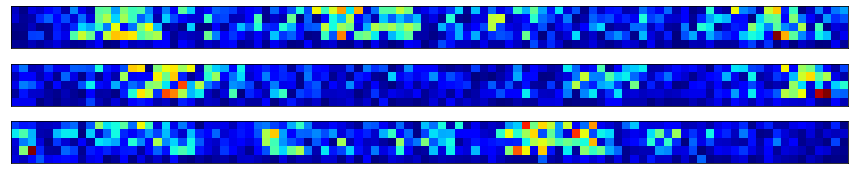

In [49]:
# Plot with 'jet' colormap to visualize as a heatmap.
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (15, 3))
ax1.imshow(grads[:][:100].T, cmap='jet')
ax1.set_yticks([])
ax1.set_xticks([])
ax2.imshow(grads[:][100:200].T, cmap='jet')
ax2.set_yticks([])
ax2.set_xticks([])
ax3.imshow(grads[:][200:].T, cmap='jet')
ax3.set_yticks([])
ax3.set_xticks([])
plt.savefig("saliency_htmap.png", orientation='landscape')

And do the attention mapping with the function `visualize_cam` on the same input. Get attention for both branches by comparing them to the specified layer **before** some compute layer. **[docs](https://raghakot.github.io/keras-vis/vis.visualization/#visualize_activation)**

Here we compare the last layer (after concatenation) attention to both of the branches inputs.

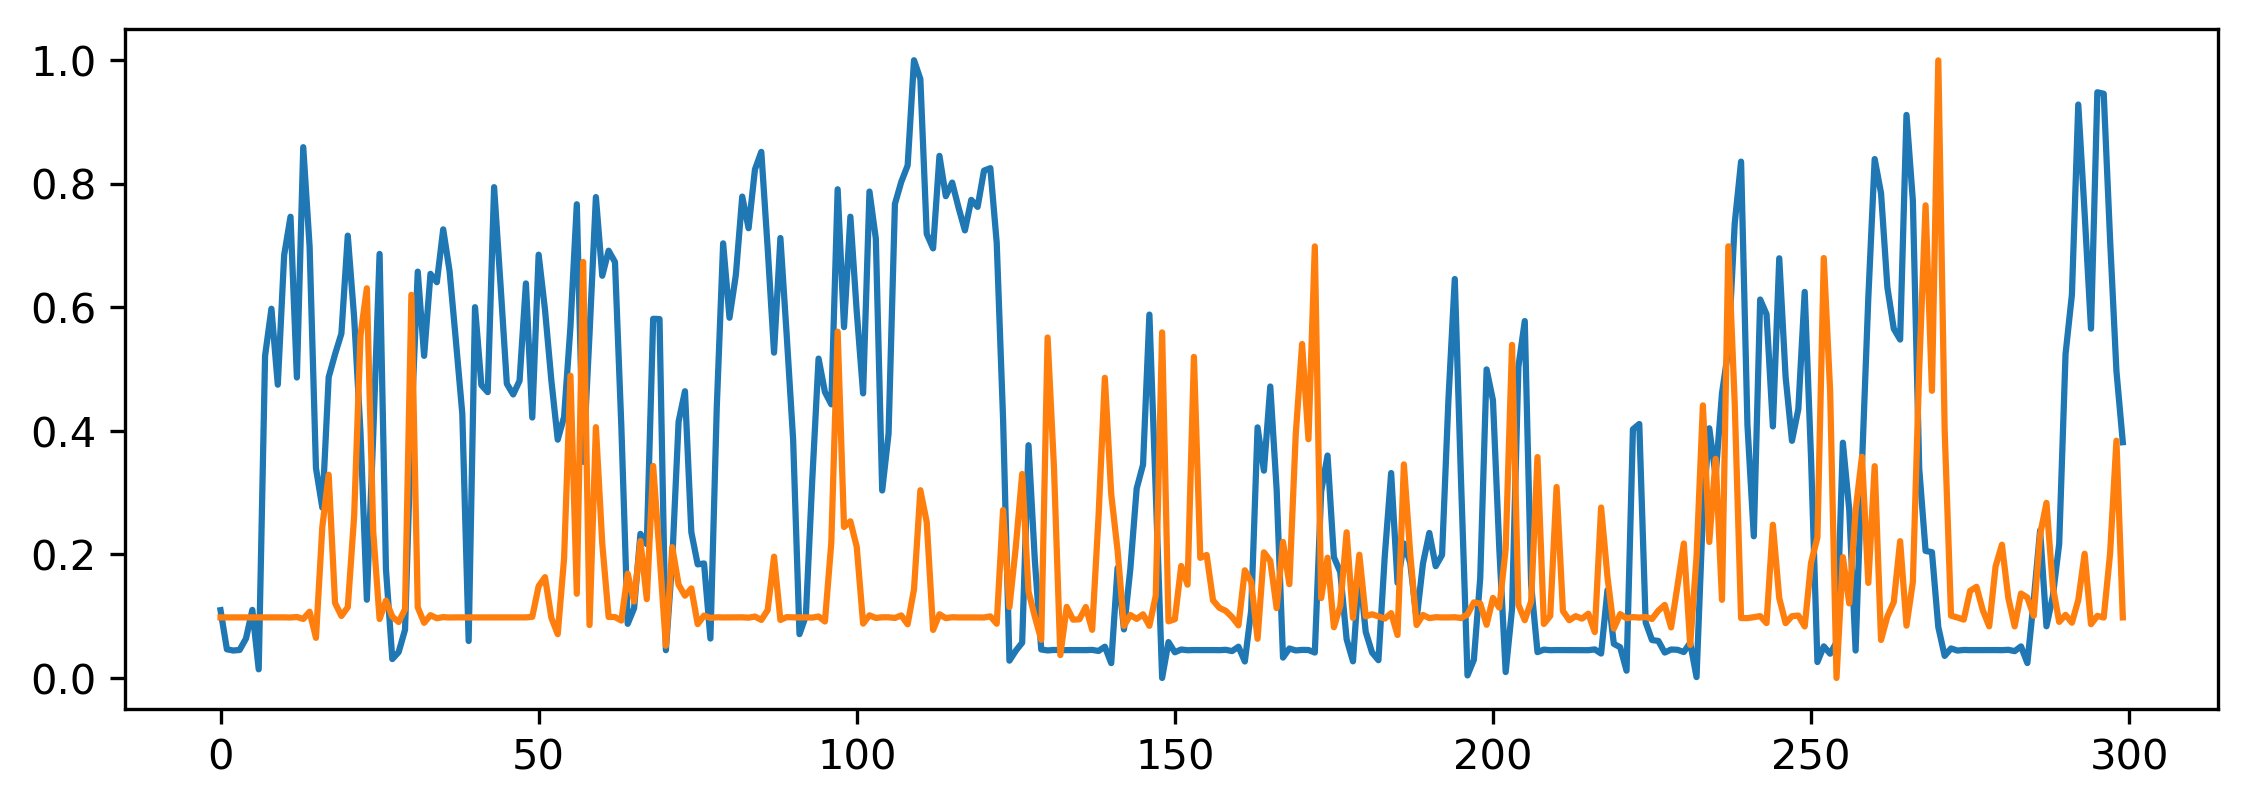

In [66]:
penultimate_uno_branch = utils.find_layer_idx(model, 
                                              'conv1d_1')
penultimate_dos_branch = utils.find_layer_idx(model, 
                                              'conv1d_2')
backproper = None

zoned_uno = visualize_cam(model, layer_idx,
                     filter_indices=None, # use'em all
                     backprop_modifier=backproper, # "guided", "relu"
                     penultimate_layer_idx=penultimate_uno_branch,
                     seed_input=val_seqs[rand_idx])

zoned_dos = visualize_cam(model, layer_idx,
                     filter_indices=None, # use'em all
                     backprop_modifier=backproper, # "guided", "relu"
                     penultimate_layer_idx=penultimate_dos_branch,
                     seed_input=val_seqs[rand_idx])

# plt.plot(zoned[:][:30])
plt.figure(figsize=(9, 3), dpi = 300)
plt.plot(zoned_uno)
plt.plot(zoned_dos)

plt.savefig("att_branches.png", orientation='landscape')

And here we add the inputs to last concatenated layer.

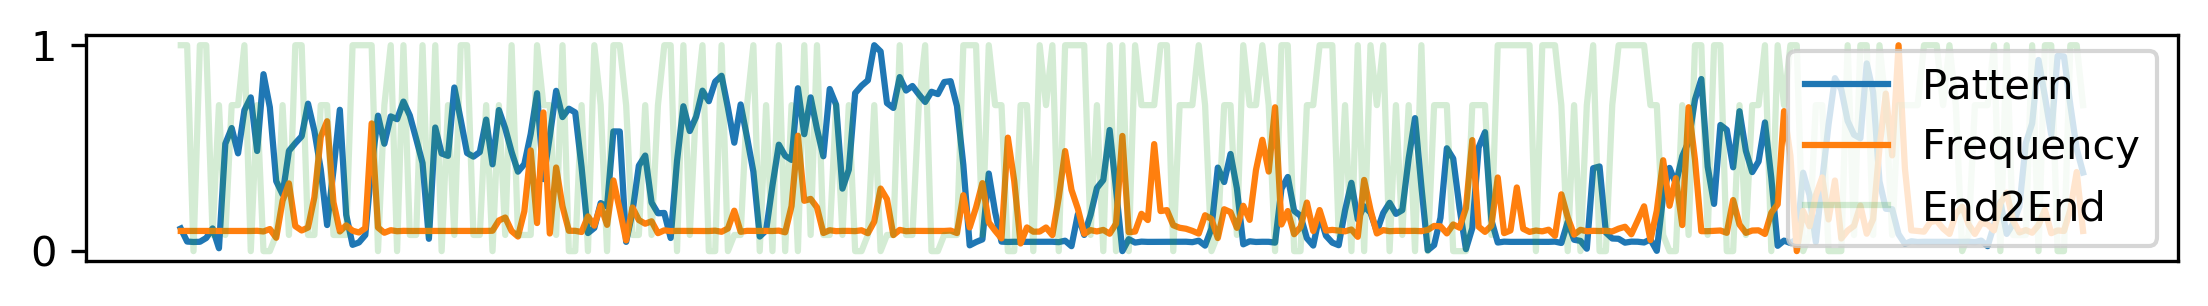

In [129]:
penultimate = utils.find_layer_idx(model, 
                                          'input_1')

zoned_tres = visualize_cam(model, layer_idx,
                     filter_indices=None, # use'em all
                     backprop_modifier=backproper, # "guided", "relu"
                     penultimate_layer_idx=penultimate,
                     seed_input=val_seqs[rand_idx])

# plt.plot(zoned[:][:30])
fig, ax1 = plt.subplots(1, figsize=(9, 1), dpi = 300)
ax1.plot(zoned_uno, label = "Pattern")
ax1.plot(zoned_dos, label = "Frequency")
ax1.plot(zoned_tres, alpha = 0.2, label = "End2End")
ax1.set_xticks([])
ax1.legend(loc='right')
plt.savefig("att_comb.png", orientation='landscape')

And then we look at what do the branches focus on given the input.

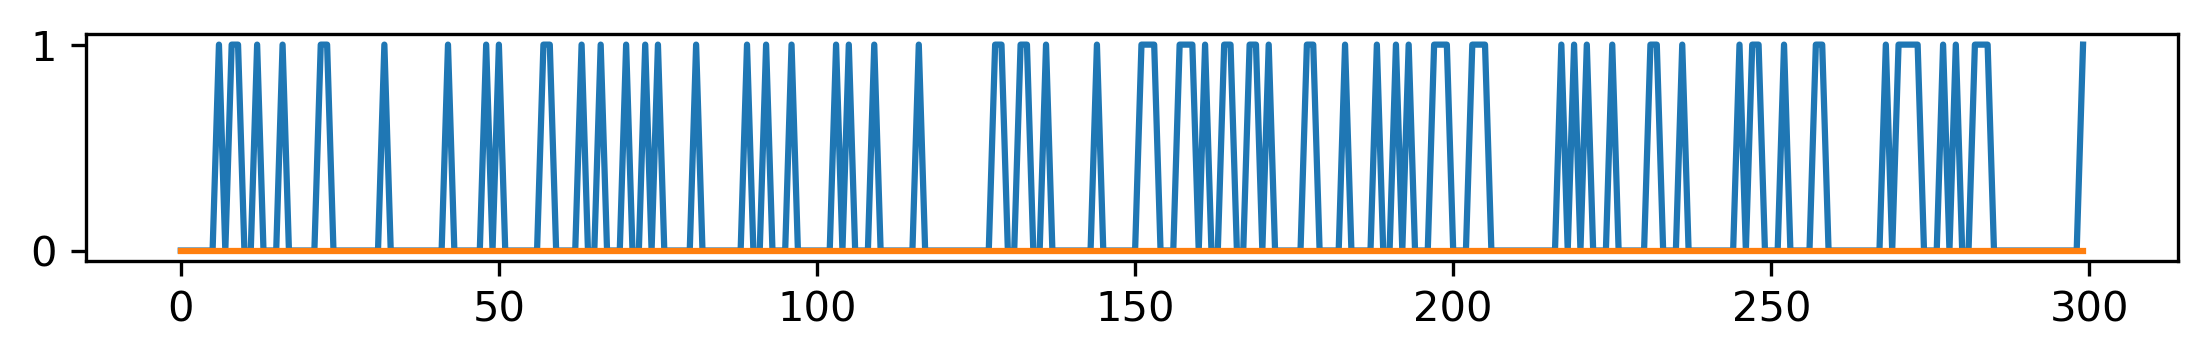

In [64]:
penultimate_uno_branch = utils.find_layer_idx(model, 'conv1d_1')
penultimate_dos_branch = utils.find_layer_idx(model, 'conv1d_2')
penultimate_input = utils.find_layer_idx(model, 'input_1')

zoned_uno = visualize_cam(model, penultimate_uno_branch,
                     filter_indices=None, # use'em all
                     backprop_modifier=backproper, # "guided", "relu"
                     penultimate_layer_idx=penultimate_input,
                     seed_input=val_seqs[rand_idx])

zoned_dos = visualize_cam(model, penultimate_dos_branch,
                     filter_indices=None, # use'em all
                     backprop_modifier=backproper, # "guided", "relu"
                     penultimate_layer_idx=penultimate_input,
                     seed_input=val_seqs[rand_idx])

# plt.plot(zoned[:][:30])

plt.figure(figsize=(9, 1), dpi = 300)
plt.plot(zoned_uno)
plt.plot(zoned_dos)
plt.savefig("att_into_branch.png", orientation='landscape')